# Telco Customer Churn Analysis

This project aims to identify factors that contribute to customer churn in a telecom company, using predictive modeling to support proactive retention strategies. I perform exploratory analysis and train multiple machine learning models, with a focus on interpreting actionable insights for the business.

**Dataset:** 7,043 customers across 33 features  
**Target:** `Churn Value` (binary: 0 = retained, 1 = churned)

Key steps:
- Data cleaning and encoding
- Exploratory visualizations
- Training Logistic Regression, Random Forest, and XGBoost models
- Evaluating model performance via accuracy and AUC
- Extracting and interpreting feature importances

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

In [2]:
df = pd.read_csv("~/Downloads/telco_customer_churn.csv")

In [3]:
df.shape

(7043, 33)

In [4]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [5]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Churn Reason    5174
dtype: int64

In [6]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [7]:
churn_counts = df["Churn Value"].value_counts()
churn_counts

0    5174
1    1869
Name: Churn Value, dtype: int64

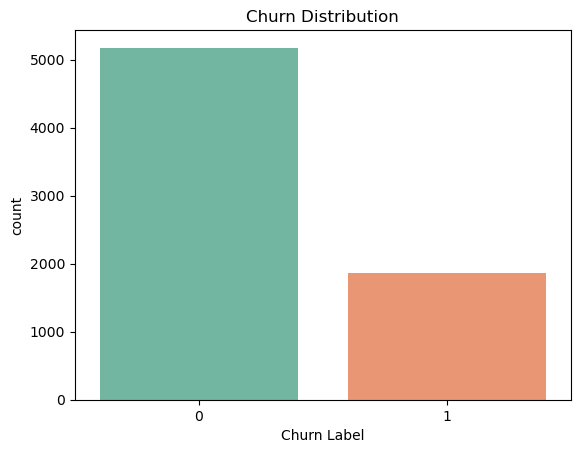

In [21]:
sns.countplot(data=df, x='Churn Label', palette='Set2')
plt.title("Churn Distribution")
plt.show()

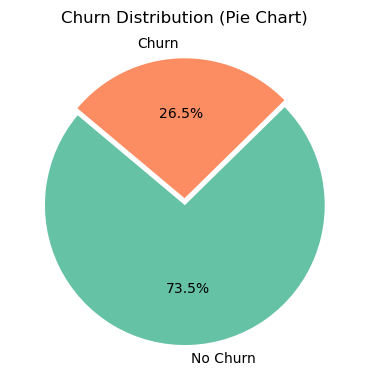

In [9]:
labels = ['No Churn', 'Churn']
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(4, 4))
plt.pie(churn_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0, 0.05))
plt.title("Churn Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

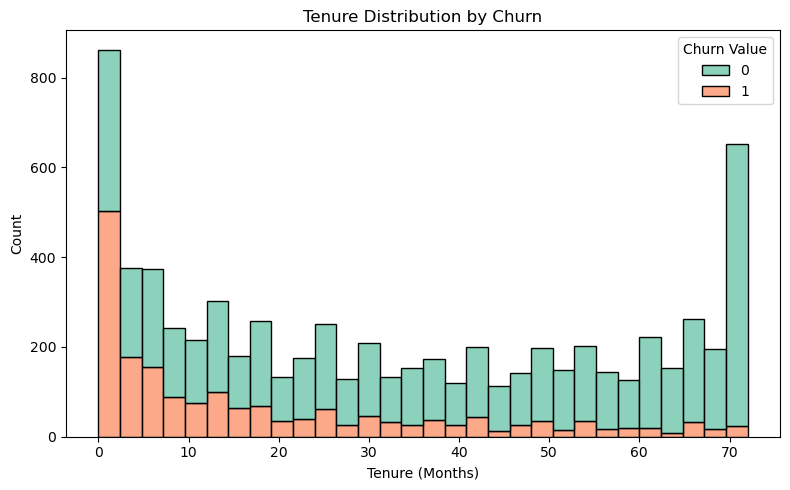

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="Tenure Months", hue="Churn Value", multiple="stack", palette="Set2", bins=30)
plt.title("Tenure Distribution by Churn")
plt.xlabel("Tenure (Months)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [11]:
df['Churn Label'] = df['Churn Label'].fillna('No')
df['Churn Label'] = df['Churn Label'].map({'Yes': 1, 'No': 0})


df.drop(columns=['CustomerID'], inplace=True)

#Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in cat_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

#Scale numerical features
scaler = StandardScaler()
num_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges']
df[num_cols] = scaler.fit_transform(df[num_cols])

## Train-Test Split

In [12]:
X = df.drop(columns=['Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason'], errors='ignore')
y = df['Churn Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Logistic Regression

In [13]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_lr))

Logistic Regression AUC: 0.8195561755664057
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.78      1409



## Random Forest

In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_rf))

Random Forest AUC: 0.8415962696013847
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1035
           1       0.65      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



## XGBoost

In [15]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_xgb))

XGBoost AUC: 0.8260843731431966
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.50      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.77      0.77      1409



The chart below shows the 10 most influential features as learned by the tuned XGBoost model.

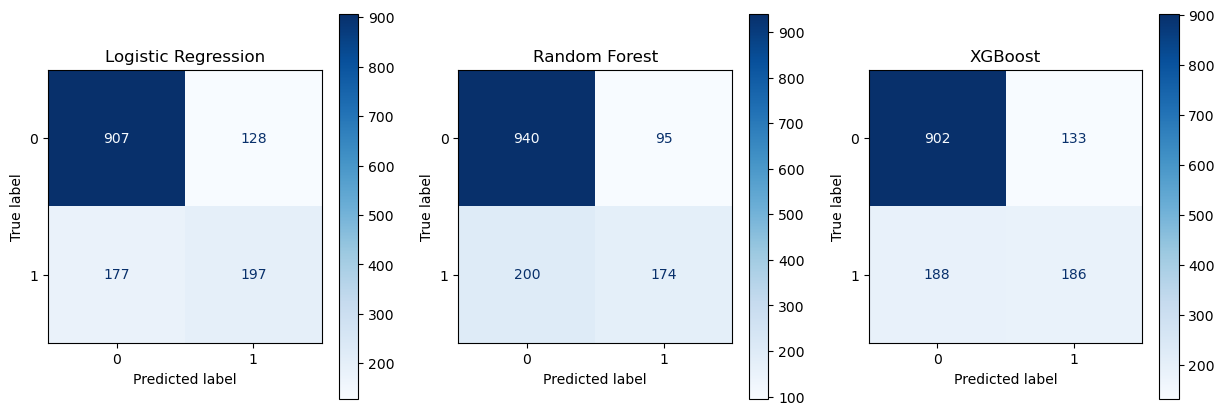

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (model, y_pred, title) in enumerate(zip([lr, rf, xgb], 
                                                 [y_pred_lr, y_pred_rf, y_pred_xgb], 
                                                 ["Logistic Regression", "Random Forest", "XGBoost"])):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap='Blues')
    axes[idx].set_title(title)

plt.show()

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_tuned = RandomizedSearchCV(XGBClassifier(eval_metric='logloss'), 
                               param_distributions=param_grid, cv=5, scoring='roc_auc', n_iter=10, random_state=42)
xgb_tuned.fit(X_train, y_train)

print("Best Parameters:", xgb_tuned.best_params_)
print("Tuned XGBoost AUC:", roc_auc_score(y_test, xgb_tuned.predict_proba(X_test)[:,1]))

Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
Tuned XGBoost AUC: 0.8534772275181484


<Figure size 1000x600 with 0 Axes>

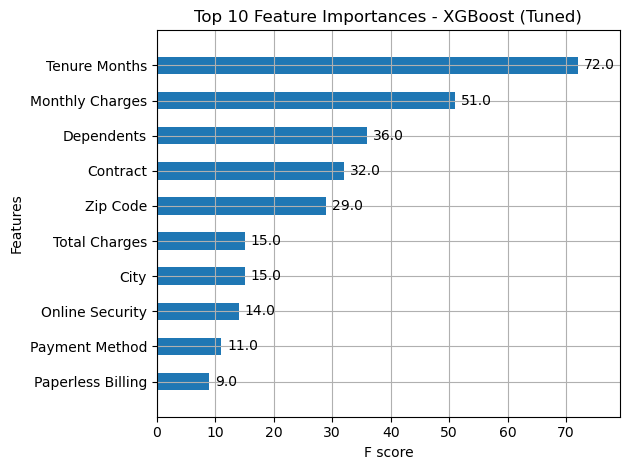

In [20]:
plt.figure(figsize=(10, 6))
plot_importance(xgb_tuned.best_estimator_, max_num_features=10, height=0.5)
plt.title("Top 10 Feature Importances - XGBoost (Tuned)")
plt.tight_layout()
plt.show()

## Save & Load Model

In [ ]:
# joblib.dump(xgb_tuned.best_estimator_, "churn_prediction_model.pkl")

# model = joblib.load("churn_prediction_model.pkl")
# y_pred_loaded = model.predict(X_test)

# print("Loaded Model AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

## Conclusion and Insights

My best-performing model (XGBoost) achieved an AUC of **85%**, indicating strong ability to distinguish between churned and retained customers.

The most influential features in predicting churn were:
- **Tenure Months**: Shorter tenure correlates strongly with churn risk
- **Contract Type**: Month-to-month customers are more likely to churn
- **Tech Support & Online Security**: Lack of these services also increased churn probability
- **Monthly Charges**: Higher monthly cost was associated with higher churn

### Recommendations:
- Offer incentives or discounts to customers in their first few months to extend tenure
- Encourage contract upgrades through personalized promotions
- Bundle Tech Support and Security services in affordable packages for at-risk users
- Regularly monitor high-charge accounts for churn risk and intervene proactively